In [1]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import math
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization

## Visualization

In [70]:
IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 16  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing

In [39]:
# Paths to the datasets
TRAIN_IMAGES_DIR = "dataset/train/images/"
TRAIN_LABELS_DIR = "dataset/train/labels/"

VAL_IMAGES_DIR = "dataset/val/images/"
VAL_LABELS_DIR = "dataset/val/labels/"

In [19]:
# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).resize(IMAGE_SIZE)  # Resize
    image = np.array(image) / 255.0  # Normalize
    return image.astype(np.float32)

In [71]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [72]:
# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [73]:
# Data loader with flexible batch size and error handling
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    # Map function to load images and annotations with error handling
    dataset = dataset.map(
        lambda x: tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [x],
            [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Apply batching, allowing for partial batches
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [74]:
# Create a resizing layer for inference
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1],
    bounding_box_format=BOUNDING_BOX_FORMAT,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO
)


In [49]:
# Function to count elements in a dataset
def count_elements(dataset):
    return dataset.cardinality().numpy()

# Check if the dataset is empty
def is_dataset_empty(dataset):
    return count_elements(dataset) <= 0

In [26]:
# Install necessary visualization libraries
!pip install matplotlib

DEPRECATION: Loading egg at c:\users\acer\anaconda3\envs\object_detection\lib\site-packages\avro_python3-1.10.2-py3.9.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [25]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [26]:
# Function to normalize image data
def normalize_image_data(image):
    # Convert TensorFlow tensor to NumPy array
    image = image.numpy()  # Explicit conversion
    # If data is in float format, scale to [0, 255]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image


In [27]:
# Function to convert from BGR to RGB if needed
def ensure_rgb_format(image):
    # If the image appears incorrect, try converting BGR to RGB
    if image.shape[-1] == 3:  # Assuming three channels (RGB or BGR)
        return image[..., ::-1]  # Reverse the color channels to convert BGR to RGB
    return image


In [103]:
import matplotlib.pyplot as plt
import math

# Visualization function with error handling for large images
def visualize_dataset(dataset, max_rows=2, max_cols=2, image_size=(224, 224), max_images=4):
    # Visualize in smaller batches to avoid memory overload
    batch = next(iter(dataset.take(1)))  # Get the first batch
    images, bounding_boxes_raw = batch


    # Extract images and raw bounding boxes
    images, bounding_boxes_raw = batch
    
    # Normalize images for plotting
    images = [image.numpy() for image in images]

    # Cap the number of images to visualize
    total_images = min(len(images), max_images)

    # Determine the number of subplots required
    rows = min(total_images, max_rows)  # Ensure rows do not exceed total images
    cols = min(math.ceil(total_images / rows), max_cols)  # Ensure valid subplot count
    
    # Adjust the figure size
    plt.figure(figsize=(4, 4), dpi=80)  # Smaller figure size and lower DPI

    for i in range(total_images):
        plt.subplot(rows, cols, i + 1)  # Define subplot layout
        plt.imshow(images[i])  # Display the image
        plt.axis("off")  # Hide axis for better visualization

        # Extract bounding boxes and class IDs
        bounding_boxes = bounding_boxes_raw[i].numpy()

        # Plot the bounding boxes
        for box in bounding_boxes:
            class_id = int(box[0])  # Class ID
            x_center = box[1] * image_size[0]  # Convert from normalized to pixel
            y_center = box[2] * image_size[1]
            width = box[3] * image_size[0]
            height = box[4] * image_size[1]

            # Convert "xywh" to "xyxy"
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2

            # Plot bounding boxes
            plt.gca().add_patch(
                plt.Rectangle(
                    (x_min, y_min),  # Top-left corner
                    x_max - x_min,  # Width
                    y_max - y_min,  # Height
                    edgecolor='red',  # Outline color
                    facecolor='none',  # No fill
                    linewidth=2,
                )
            )

            # Annotate class ID
            plt.text(
                x_min, y_min - 10,
                f"Class {class_id}",
                color='red',  # Text color
                fontsize=10,
                backgroundcolor='white'  # Background for visibility
            )

    # Avoid tight_layout issues by reducing excess padding/margins
    try:
        plt.tight_layout()  # Adjust layout to avoid overlap
    except UserWarning:
        pass  # If tight layout doesn't work, proceed without it

    plt.show()  # Display the plots


In [104]:
# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE//2)

In [102]:
visualize_dataset(train_dataset)


C:\Users\acer\AppData\Local\Temp\ipykernel_18960\3937991220.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to avoid overlap


ValueError: num must be an integer with 1 <= num <= 4, not 5

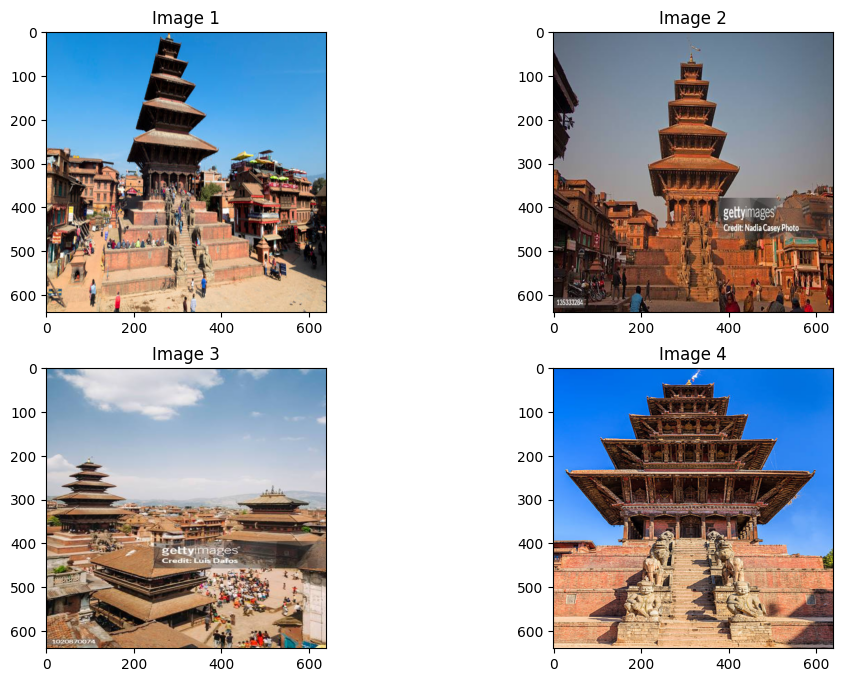

In [78]:
visualize_dataset(val_dataset)

In [69]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
val_dataset = val_dataset.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

TypeError: too many positional arguments